This notebook is to develop algorithm to reconstruct voltage measurement

In [1]:
# import used functioons 
#  import tools 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.utils import plot_model
import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

Import the path of test files

In [2]:
# 開啟互動模式
%matplotlib widget


# Data set folder 
NTU_dataset_path = r'D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data'

# 只引入 15kg_1V_1800rpm_1的資料

# -----------------------10psi data--------------------

collect_setting = r"Load_1V\Speed_1800\Pressure_10psi"
test_files_path=(os.path.join(NTU_dataset_path, collect_setting, r"15kg_1V_1800rpm_1"))

# 確認 train_file_list 中的所有路徑是否存在
print(os.path.exists(test_files_path))

# 取出 rul2_dataset_path 中的所有 file 名稱並按照順序排列
rul2_files = [f for f in os.listdir(test_files_path) if os.path.isfile(os.path.join(test_files_path, f))]
rul2_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))
# 將每一個 rul2_files 檔案都與 test_files_path 路徑合併，得到完整路徑列表
rul2_files = [os.path.join(test_files_path, f) for f in rul2_files]


True


檢視單筆採樣狀況

Voltage alpha THD of file 1: 0.1670
Voltage alpha THD of file 2: 0.1831
Voltage alpha THD of file 3: 0.2575
Voltage alpha THD of file 4: 0.2024
Voltage alpha THD of file 5: 0.0559
Voltage alpha THD of file 6: 0.0710
Voltage alpha THD of file 7: 0.0751
Voltage alpha THD of file 8: 0.2629
Voltage alpha THD of file 9: 0.1953
Voltage alpha THD of file 10: 0.1289
Voltage alpha THD of file 11: 0.1940
Voltage alpha THD of file 12: 0.0624
Voltage alpha THD of file 13: 0.2478
Voltage alpha THD of file 14: 0.0525
Voltage alpha THD of file 15: 0.0534
Voltage alpha THD of file 16: 0.1879
Voltage alpha THD of file 17: 0.1592
Voltage alpha THD of file 18: 0.1649
Voltage alpha THD of file 19: 0.1598
Voltage alpha THD of file 20: 0.0651
Voltage alpha THD of file 21: 0.1367
Voltage alpha THD of file 22: 0.0771
Voltage alpha THD of file 23: 0.0523
Voltage alpha THD of file 24: 0.1374
Voltage alpha THD of file 25: 0.0966
Voltage alpha THD of file 26: 0.0582
Voltage alpha THD of file 27: 0.2227
Voltage al

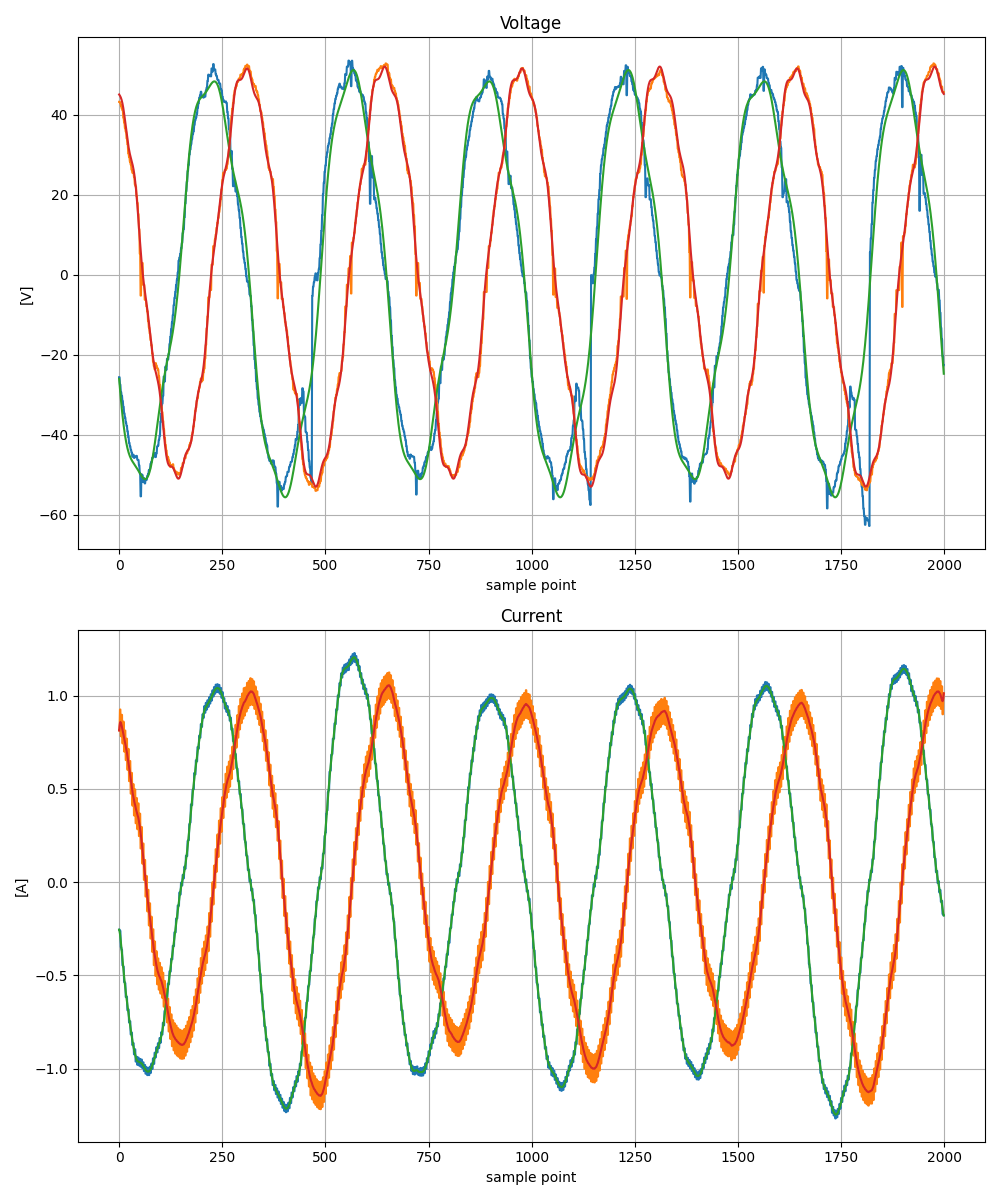

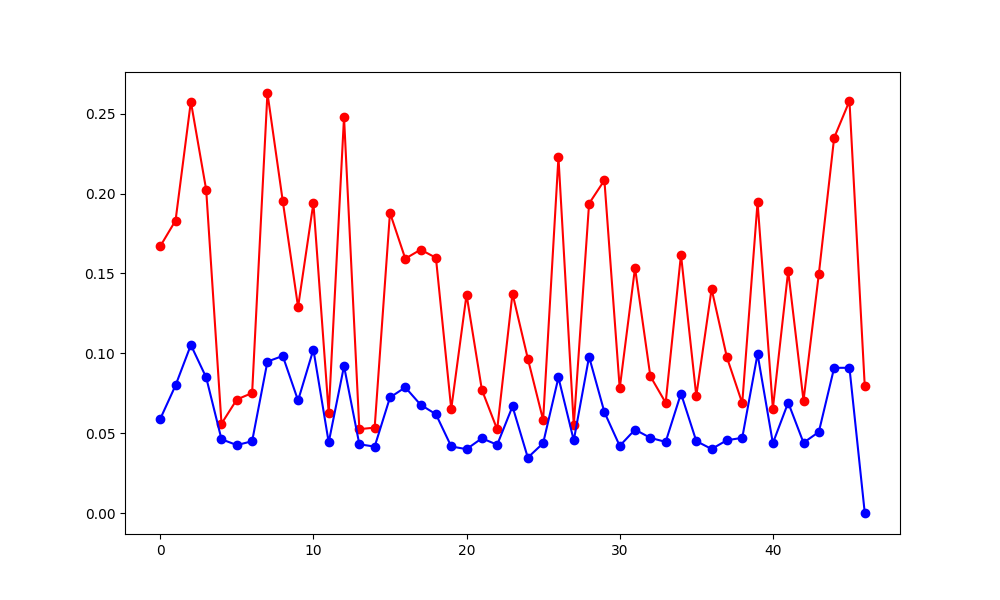

In [9]:
def plot_electrical_sample(sampled_data):
   
    fig = plt.figure(figsize=(10, 12))

    # Subplot for voltage
    plt.subplot(2, 1, 1)
    plt.plot(sampled_data["Voltage alpha"], linestyle='-')
    plt.plot(sampled_data["Voltage beta"], linestyle='-')
    plt.plot(sampled_data["Voltage alpha downsample"], linestyle='-')
    plt.plot(sampled_data["Voltage beta downsample"], linestyle='-')
    
    
    plt.xlabel("sample point")
    plt.ylabel("[V]")
    plt.title("Voltage")
    plt.grid()

    # Subplot for Current
    plt.subplot(2, 1, 2)
    plt.plot(sampled_data["Current alpha"], linestyle='-')
    plt.plot(sampled_data["Current beta"], linestyle='-')
    plt.plot(sampled_data["Current alpha downsample"], linestyle='-')
    plt.plot(sampled_data["Current beta downsample"], linestyle='-')
    
    plt.xlabel("sample point")
    plt.ylabel("[A]")
    plt.title("Current")
    plt.grid()
    
    plt.tight_layout()
    
    return fig

def calculate_thd(signal):
    """
    Calculate Total Harmonic Distortion (THD) of a 1D numpy array.
    """
    signal = np.squeeze(signal)
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N)
    fft_mags = np.abs(fft_vals)[:N // 2]
    # Find the index of the fundamental frequency (ignore DC)
    fundamental_idx = np.argmax(fft_mags[1:]) + 1
    fundamental_mag = fft_mags[fundamental_idx]
    # Harmonics: 2nd, 3rd, ..., up to Nyquist
    harmonics_mag = np.sqrt(np.sum(fft_mags[fundamental_idx*2:]**2))
    thd = harmonics_mag / fundamental_mag
    return thd

def filter_top_n_frequencies(signal, n):
    """
    保留頻譜中前 n 個最大振幅的頻率分量，其餘設為 0，並還原時域訊號。

    Parameters:
    signal : 1D numpy array
        輸入的時域訊號。
    n : int
        要保留的最大頻率分量個數（不含DC）。

    Returns:
    filtered_signal : 1D numpy array
        經過濾波處理後的時域訊號。
    filtered_fft : 1D numpy array (complex)
        經過濾波的頻域資訊。
    """
    signal = np.squeeze(signal)
    N = len(signal)

    # FFT 及頻率
    fft_vals = np.fft.fft(signal)
    fft_mags = np.abs(fft_vals)

    # 忽略 DC 分量（index 0）來尋找最大值
    indices = np.argsort(fft_mags[1:N//2])[-n:] + 1  # +1 是因為跳過 DC

    # 建立遮罩，只保留前 n 個
    mask = np.zeros_like(fft_vals, dtype=bool)
    mask[indices] = True
    mask[-indices] = True  # 同步保留負頻率分量

    # DC 也可以選擇保留
    mask[0] = True

    # 應用遮罩
    filtered_fft = np.zeros_like(fft_vals, dtype=complex)
    filtered_fft[mask] = fft_vals[mask]

    # IFFT 還原時域訊號
    filtered_signal = np.fft.ifft(filtered_fft).real

    return filtered_signal, filtered_fft


idx1=2
sampled_data=read_rul_data(rul2_files[3])
plot_electrical_sample(sampled_data)


thd_voltage_alpha_total=[]
thd_voltage_alpha_total_filter=[]
# 統計所有電壓和電流的 THD 值
for i in range(len(rul2_files)):
    # Example usage:
    voltage_alpha = read_rul_data(rul2_files[i])["Voltage alpha"]
    thd_voltage_alpha = calculate_thd(voltage_alpha)
    
    print(f"Voltage alpha THD of file {i+1}: {thd_voltage_alpha:.4f}")
    thd_voltage_alpha_total.append(calculate_thd(read_rul_data(rul2_files[i])["Voltage alpha"]))
    thd_voltage_alpha_total_filter.append(calculate_thd(read_rul_data(rul2_files[i])["Voltage alpha downsample"]))
plt.figure(figsize=(10, 6))
plt.plot(thd_voltage_alpha_total, marker='o', linestyle='-', color='r')
plt.plot(thd_voltage_alpha_total_filter, marker='o', linestyle='-', color='b')

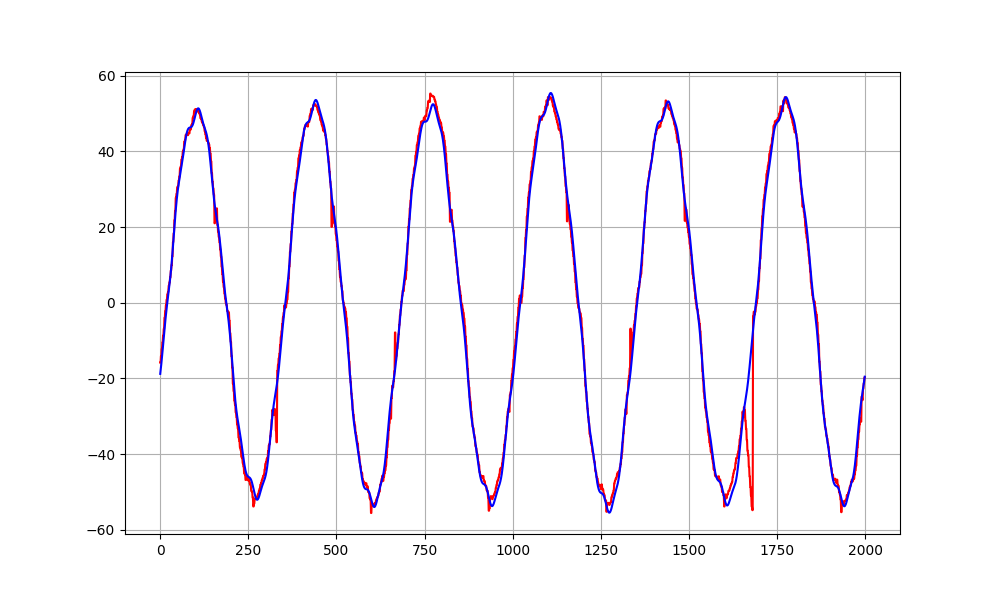

In [4]:

voltage_alpha = read_rul_data(rul2_files[24])["Voltage alpha"]
filtered_voltage,_=filter_top_n_frequencies(voltage_alpha, 5)
plt.figure(figsize=(10, 6))
plt.plot(voltage_alpha, linestyle='-', color='r')
plt.plot(filtered_voltage, linestyle='-', color='b')
plt.grid()

In [5]:
print(rul2_files[idx1])

D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_1V\Speed_1800\Pressure_10psi\15kg_1V_1800rpm_1\RUL_Data_3_4.parquet
